# Qredo tokenomics simulation - single run example

#### Maria Silva, June 2023

## 1. Imports

In [1]:
import os
import timeit
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

from mechaqredo.params import default_params_dict
from mechaqredo.sim import run_single_sim

## 2. Set parameters

In [3]:
forecast_length = 365*3
file = os.path.realpath("../data/balances.csv")
wallet_df = pd.read_csv(file)
params_dict = default_params_dict(forecast_length)
params_dict["wallet_balances_vec"] = wallet_df["balance"].values

## 3. Run simulation

In [4]:
start = timeit.default_timer()
df = run_single_sim(forecast_length, params_dict)
stop = timeit.default_timer()
print("Run time for single sim: ", stop - start)
print("")
df["date"] = df["iteration"].apply(lambda x: params_dict["sim_start_datetime"]+dt.timedelta(days=x)).values
df.head()

Run time for single sim:  0.007443750000000193



,iteration,circ_supply,day_burned_vec,day_vested_vec,day_locked_vec,day_released_vec,vested_vec_from_staking,total_staking_rewards_vec,validators_rewards_vec,market_cap,day_burn_fees_vec,day_service_fee_locked_vec,ecosystem_fund_vec,n_txs_vec,token_price_vec,service_fees_vec,n_val_vec,day_inflation,year_inflation,date
0,0,4.222564e+08,350000004.0,5.150000e+08,1.777436e+08,1.750000e+08,0.000000,0.000000e+00,0.000000e+00,3.378051e+07,4.0,11193.75,1.100000e+08,8000.0,0.08,3000.0,6.0,NaN,NaN,2023-07-15
1,1,4.623286e+08,4.0,2.551592e+05,1.219375e+04,3.982927e+07,94929.132588,3.992420e+07,1.996210e+07,3.698629e+07,4.0,11193.75,7.018192e+07,8000.0,0.08,3000.0,6.0,0.094900,NaN,2023-07-16
2,2,4.789038e+08,4.0,9.488407e+04,9.993244e+06,2.647359e+07,94884.074887,2.656848e+07,1.328424e+07,3.831231e+07,4.0,11193.75,4.371952e+07,8000.0,0.08,3000.0,6.0,0.035852,NaN,2023-07-17
3,3,4.892438e+08,4.0,9.483904e+04,6.654313e+06,1.689945e+07,94839.038572,1.699429e+07,8.497144e+06,3.913950e+07,4.0,11193.75,2.683127e+07,8000.0,0.08,3000.0,6.0,0.021591,NaN,2023-07-18
4,4,5.007586e+08,4.0,5.251131e+06,4.260766e+06,1.052438e+07,94794.023634,1.061917e+07,5.309585e+06,4.006068e+07,4.0,11193.75,1.631808e+07,8000.0,0.08,3000.0,6.0,0.023536,NaN,2023-07-19


## 4. Visualize results

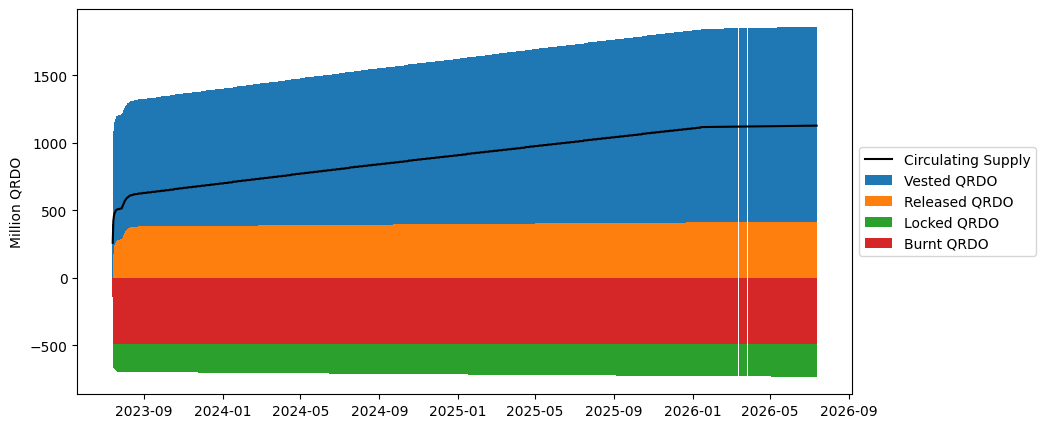

In [5]:
# Get values before sim
circ_supply_0 = np.array([params_dict["circ_supply_zero"]])
cum_burn_0 = np.array([140_000_000.0])
cum_vest_0 = np.array([params_dict["circ_supply_zero"]+140_000_000])
cum_lock_0 = np.array([0.0])
cum_release_0 = np.array([0.0])
date_0 = np.array([params_dict["sim_start_datetime"]-dt.timedelta(days=1)], dtype='datetime64[ns]')

# Build data vectors
circ_supply_vec = np.concatenate([circ_supply_0, df["circ_supply"].values])/ 10 ** 6
cum_burn_vec = np.concatenate([cum_burn_0, df["day_burned_vec"].values]).cumsum()/ 10 ** 6
cum_vest_vec = np.concatenate([cum_vest_0, df["day_vested_vec"].values]).cumsum()/ 10 ** 6
cum_lock_vec = np.concatenate([cum_lock_0, df["day_locked_vec"].values]).cumsum()/ 10 ** 6
cum_release_vec = np.concatenate([cum_release_0, df["day_released_vec"].values]).cumsum()/ 10 ** 6
date_vec = np.concatenate([date_0, df["date"].values])

# Plot supply
plt.figure(figsize=(10,5))
bar_width = 0.999
plt.bar(date_vec, cum_vest_vec+cum_release_vec, label="Vested QRDO",width=bar_width)
plt.bar(date_vec, cum_release_vec, label='Released QRDO',width=bar_width)
plt.bar(date_vec, -cum_lock_vec-cum_burn_vec, label="Locked QRDO",width=bar_width)
plt.bar(date_vec, -cum_burn_vec, label="Burnt QRDO",width=bar_width)
plt.plot(date_vec, circ_supply_vec, label="Circulating Supply", c="black")
plt.ylabel("Million QRDO")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

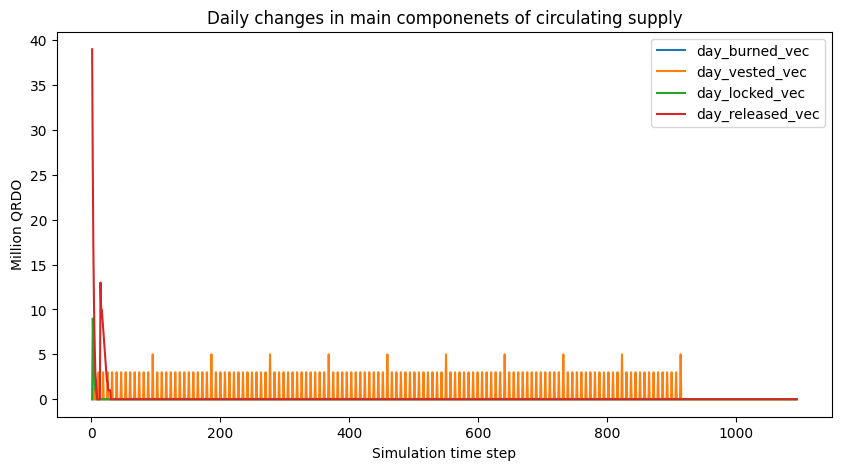

In [6]:
day_var_df = df[['day_burned_vec', 'day_vested_vec','day_locked_vec', 'day_released_vec']]// 10 ** 6
day_var_df.iloc[1:].plot(figsize=(10,5))
plt.title("Daily changes in main componenets of circulating supply")
plt.xlabel("Simulation time step")
plt.ylabel("Million QRDO")
plt.show()

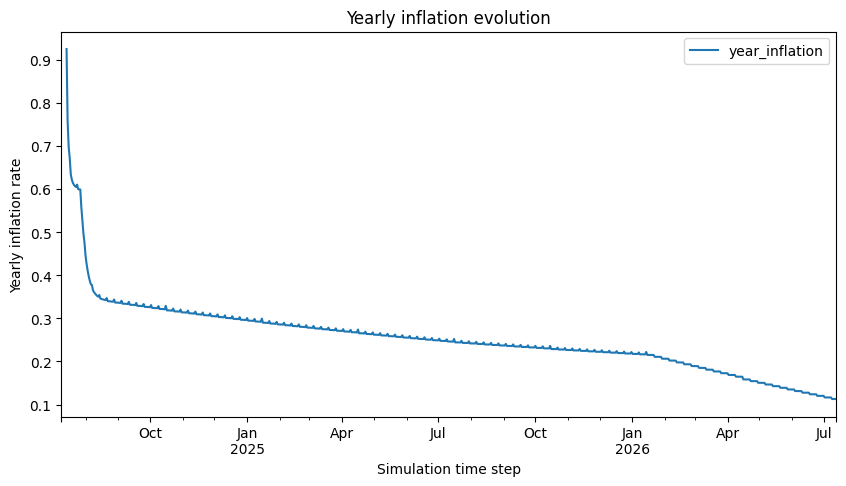

In [7]:
df.iloc[360:].plot(x="date", y="year_inflation", figsize=(10,5))
plt.title("Yearly inflation evolution")
plt.xlabel("Simulation time step")
plt.ylabel("Yearly inflation rate")
plt.show()